# [3주차] 기본과제: DistilBERT로 뉴스 기사 분류 모델 학습하기

In [1]:
# !pip install tqdm boto3 requests regex sentencepiece sacremoses datasets safetensors transformers tokenizers matplotlib  torchinfo

# [MY CODE] AG_News dataset 준비
## ✅ Huggingface dataset의 fancyzhx/ag_news를 load합니다.
## ✅ Truncation과 관련된 부분들을 지웁니다.

In [2]:
import torch

# 1. 필요한 라이브러리 임포트
from datasets import load_dataset

###################################################################################################
# ✅ Huggingface dataset의 fancyzhx/ag_news를 load합니다.
###################################################################################################
# 2. 데이터셋 로드
ds = load_dataset("fancyzhx/ag_news")
# ds는 일반적으로 DatasetDict 형태로, { "train": Dataset, "test": Dataset } 같은 스플릿을 가질 수 있음.

# 3. 데이터셋의 전반적 정보 확인
# print(ds)는 스플릿 이름, 샘플 수, 컬럼 등을 요약해서 보여줌
print("\n=== Dataset Info ===")
print(ds)

# 4. 구체적으로 train 스플릿의 정보를 보고 싶다면
train_ds = ds["train"]
print("\n=== Train Dataset Info ===")
print(train_ds)

# 5. train 스플릿의 크기(행 개수) 확인
print("\n=== Train Dataset Length(행 개수) ===")
print(len(train_ds))

# 6. train 스플릿의 컬럼 이름, 타입, 라벨 항목 등을 확인
# features 객체에는 각 컬럼의 스키마가 정의되어 있음
print("\n=== Train Dataset Features ===")
print(train_ds.features)

# 7. 라벨(=카테고리) 목록 확인
# 'label'이라는 컬럼이 ClassLabel 타입이라면 .names 로 전체 라벨명을 확인 가능
if "label" in train_ds.features and hasattr(train_ds.features["label"], "names"):
    label_names = train_ds.features["label"].names
    print("\n=== Label Names ===")
    print(label_names)

# 8. 실제 데이터 예시 확인
# 첫 번째 샘플을 보려면 아래처럼 사용 (keys: 컬럼명)
print("\n=== First sample of train dataset ===")
print(train_ds[0])

# 9. 특정 컬럼들만 보고 싶다면
print("\n=== Just text and label of the first sample ===")
print({
    "text": train_ds[0]["text"],
    "label": train_ds[0]["label"]
})

# 10. DistilBERT 기반 토크나이저 로드
#     huggingface/pytorch-transformers 레포지토리에서 'distilbert-base-uncased' 토크나이저를 불러옴
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

# 11. 배치를 텐서 형태로 변환해줄 collate_fn 함수 정의
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  # 텍스트 리스트를 토크나이저로 처리: 정수 인덱스 시퀀스로 변환
  # - padding=True : 가장 긴 시퀀스 길이에 맞춰 패딩
  # - truncation=True : 지정한 max_length를 초과하면 잘라냄
  # - max_length=max_len : 최대 토큰 길이, None이면 trucation 무시
  # .input_ids: 실제 토큰화된 결과(정수 리스트)를 반환
  ###################################################################################################
  # ✅ Truncation과 관련된 부분들을 지웁니다.
  ###################################################################################################
  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=False, max_length=None).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels

# 12. PyTorch DataLoader 임포트
from torch.utils.data import DataLoader

# 13. 훈련용 DataLoader 생성
#     - ds['train']: 훈련 데이터셋
#     - batch_size=64 : 한 배치에 64개 샘플씩 불러옴
#     - shuffle=True : 매 에폭마다 데이터를 섞어 순서가 달라지게 함
#     - collate_fn=collate_fn : 배치를 텐서 형태로 변환하는 함수를 지정
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 14. 테스트용 DataLoader 생성
#     - ds['test']: 테스트 데이터셋
#     - batch_size=64 : 한 배치에 64개 샘플
#     - shuffle=False : 테스트 시에는 보통 순서를 섞지 않음
#     - collate_fn=collate_fn : 동일한 collate_fn 사용
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)



/opt/anaconda3/envs/hanghae99_plusAI_2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Dataset Info ===
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

=== Train Dataset Info ===
Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

=== Train Dataset Length(행 개수) ===
120000

=== Train Dataset Features ===
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}

=== Label Names ===
['World', 'Sports', 'Business', 'Sci/Tech']

=== First sample of train dataset ===
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}

=== Just text and label of the first sample ===
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}

Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [3]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

# DistilBERT 모델 구조 분석
# DistilBERT는 BERT의 경량화 버전으로, BERT의 12개 레이어 중 절반인 6개 레이어만 사용해 추론 속도는 약 60% 향상
# 파라미터 수는 약 66M으로, BERT Base(110M)보다 적지만 GLUE 벤치마크 기준 약 95%의 성능 유지

# 1. Embeddings Layer
# - word_embeddings: 30522개의 토큰(단어)을 768차원의 벡터로 임베딩
# - position_embeddings: 최대 512개의 위치 정보(문장 길이)를 임베딩해 문장 내 위치 정보 반영
# - LayerNorm: 임베딩 결과를 정규화해 안정성 향상
# - Dropout: 과적합 방지를 위해 10% 확률로 드롭아웃 적용
#
# 예시: Embedding(30522, 768) -> 30522개의 단어를 768차원으로 변환
#       Embedding(512, 768) -> 문장 내 최대 512개 위치를 768차원으로 변환
#
# output: (batch_size, sequence_length, hidden_size=768)
#
# 예: 입력 토큰 시퀀스 -> 임베딩 -> (B, L, 768)

# 2. Transformer Layer
# - 6개의 Transformer Block 사용 (BERT의 절반)
# - 각 블록은 Self-Attention 및 Feed Forward Network(FFN)으로 구성
# - Multi-Head Self-Attention: 768차원의 입력에 대해 쿼리(Q), 키(K), 값(V) 연산
# - Linear(768 -> 768): 어텐션 결과를 다시 768차원으로 변환
# - LayerNorm: Self-Attention 후 정규화 적용
#
# MultiHeadSelfAttention:
# - q_lin, k_lin, v_lin: Linear(768, 768)
# - out_lin: Linear(768, 768)
#
# Feed Forward Network(FFN):
# - lin1: Linear(768 -> 3072)  # 차원 확장 (4배 증가)
# - lin2: Linear(3072 -> 768)  # 다시 768차원으로 축소
# - 활성화 함수: GELU(Gaussian Error Linear Unit) 사용
# - Dropout: FFN에도 드롭아웃 10% 적용
#
# output: (batch_size, sequence_length, hidden_size=768)

# 3. 주요 하이퍼파라미터
# - hidden_size = 768: 모든 임베딩 및 레이어 출력 차원
# - intermediate_size = 3072: FFN의 확장 차원 (hidden_size의 4배)
# - num_hidden_layers = 6: 총 6개의 Transformer 레이어
# - num_attention_heads = 12: 12개의 어텐션 헤드 사용
# - dropout = 0.1: Dropout 확률 10%

# 4. 성능 및 비교
# - BERT Base 대비 40% 가벼우며, 속도는 약 60% 향상
# - GLUE 벤치마크에서 BERT의 95% 성능 유지
# - 추론이 빠르고 메모리 효율이 높아 실시간 어플리케이션에 적합

# 5. DistilBERT vs BERT 비교
# | 항목                  | BERT Base           | DistilBERT        |
# |-----------------------|---------------------|-------------------|
# | 레이어 수             | 12                  | 6                 |
# | 파라미터 수           | 110M                | 66M               |
# | 임베딩 차원           | 768                 | 768               |
# | FFN 차원              | 3072                | 3072              |
# | 추론 속도             | 느림                | 약 60% 더 빠름     |
# | 성능 (GLUE)           | 100%                | 95%               |

Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

# [MY CODE] Classifier output, loss function, accuracy function 변경
## ✅ TextClassifier의 출력 차원을 잘 조정

In [4]:
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self, num_classes=4):
    super().__init__()

    # DistilBERT 모델 로드
    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

    ###################################################################################################
    # ✅ TextClassifier의 출력 차원을 잘 조정
    ###################################################################################################
    # 분류기: DistilBERT hidden size(768) -> 다중 분류 클래스 수(4)
    self.classifier = nn.Linear(768, num_classes)

  def forward(self, x):
    # DistilBERT 인코더를 통과하여 hidden state 추출
    # last_hidden_state는 최종 인코더에서 문장 내 모든 토큰에 대한 임베딩 정보
    x = self.encoder(x)['last_hidden_state']

    # 첫 번째 토큰([CLS])을 가져와 분류기에 전달
    x = self.classifier(x[:, 0])

    return x



model = TextClassifier()

"""
param.requires_grad = False를 통해 model.encoder(DistilBERT 인코더)의 모든 파라미터가
역전파(Gradient Descent)에서 업데이트되지 않도록 설정한다.

 -> 전이 학습(Transfer Learning)

 주요 의도
	1.	사전 학습된 DistilBERT 인코더를 그대로 사용하고, 분류기(classifier) 부분만 학습합니다.
        사전 학습된 언어 모델의 정보는 그대로 유지하고, 텍스트 분류기를 학습시키는 방식입니다.
	    새로운 데이터셋에 맞게 **분류기 헤드(FC 레이어)**만 조정하면 빠르게 성능을 확보할 수 있습니다.
	2.	학습 속도 및 자원 절약
	    DistilBERT의 인코더는 수백만 개의 파라미터로 이루어져 있으며, 이를 업데이트하는 데 많은 시간이 걸립니다.
	    인코더를 동결하면 계산량이 크게 줄어 학습 속도가 빨라지고, 메모리 사용량이 절감됩니다.
	3.	과적합 방지
	    작은 데이터셋에서 전체 모델을 학습시키면 과적합(overfitting)될 가능성이 높습니다.
	    인코더를 동결하고, 분류기만 학습하면 일반화 성능이 더 높아질 수 있습니다.
"""
for param in model.encoder.parameters():
  param.requires_grad = False

Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


## ✅ accuracy function 변경

In [5]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

In [6]:
max_len = 0
for batch in train_loader:
    lengths = [len(text) for text in batch[0]]
    batch_max = max(lengths)
    max_len = max(max_len, batch_max)

print(f"Train 데이터셋 최대 문장 길이: {max_len}")
# 배치 내 문장이 자동으로 가장 긴 문장에 맞게 패딩됩니다.

Train 데이터셋 최대 문장 길이: 379


In [7]:
from torchinfo import summary

# 모델 정보 출력
summary(model, input_size=(64, 512), dtypes=[torch.int64])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                  Output Shape              Param #
TextClassifier                                          [64, 4]                   --
├─DistilBertModel: 1-1                                  [64, 512, 768]            --
│    └─Embeddings: 2-1                                  [64, 512, 768]            --
│    │    └─Embedding: 3-1                              [64, 512, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 512, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 512, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 512, 768]            --
│    └─Transformer: 2-2                                 [64, 512, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [64, 4]                   3,076
Total params: 66,365,956


In [8]:
# 1. CUDA(엔비디아 GPU) -> 2. MPS(Apple GPU) -> 3. CPU 순서로 디바이스 선택
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")

print(f"Using device: {device}")

Using device: mps


# [MY CODE] 훈련
## Save/Load
## ✅ nn.CrossEntropyLoss 를 추가

In [9]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import time

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10
start_epoch = 0

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []

checkpoint_path = '3_checkpoint_TextClassifier.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")


for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

        end_time = time.time()
        epoch_time = end_time - start_time  # 에포크 실행 시간 계산


    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 88.16 seconds | Loss: 0.47 | Train Acc: 0.877 | Test Acc: 0.873
Epoch   2 | Time: 90.21 seconds | Loss: 0.37 | Train Acc: 0.884 | Test Acc: 0.880
Epoch   3 | Time: 91.01 seconds | Loss: 0.36 | Train Acc: 0.889 | Test Acc: 0.886
Epoch   4 | Time: 91.95 seconds | Loss: 0.35 | Train Acc: 0.890 | Test Acc: 0.886
Epoch   5 | Time: 91.93 seconds | Loss: 0.35 | Train Acc: 0.891 | Test Acc: 0.888
Epoch   6 | Time: 91.32 seconds | Loss: 0.35 | Train Acc: 0.888 | Test Acc: 0.886
Epoch   7 | Time: 91.35 seconds | Loss: 0.34 | Train Acc: 0.892 | Test Acc: 0.887
Epoch   8 | Time: 91.51 seconds | Loss: 0.34 | Train Acc: 0.892 | Test Acc: 0.887
Epoch   9 | Time: 90.97 seconds | Loss: 0.34 | Train Acc: 0.889 | Test Acc: 0.887
Epoch  10 | Time: 92.22 seconds | Loss: 0.34 | Train Acc: 0.893 | Test Acc: 0.888


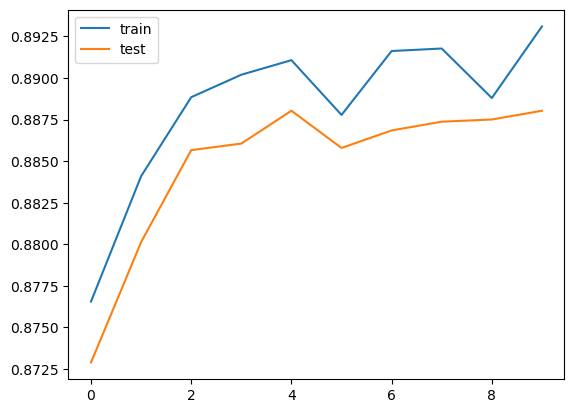

In [10]:
plot_acc(train_accuracies, test_accuracies)